In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


  **Overview: Purpose of this notebook is to explore the targeted privacy tests and run simple logistic regression model.**

* Preprocessing the json data and converting it into tabular format.

In [3]:
# load json file into pandas dataframe
import pandas as pd
import json
import warnings

warnings.filterwarnings("ignore")
pd.set_option("mode.copy_on_write", True)

json_data = open("/content/drive/MyDrive/sample_data_1205.json").read()
data = json.loads(json_data)
df = pd.DataFrame(data)

# expand column of dictionaries into separate columns
df = pd.concat(
    [df.drop(["genconfig"], axis=1), df["genconfig"].apply(pd.Series)], axis=1
)
df = pd.concat([df.drop(["metadata"], axis=1), df["metadata"].apply(pd.Series)], axis=1)
# drop unnecessary columns
df.drop(["quality", "product_version", "runtime_end"], axis=1, inplace=True)

# for each unique schema, create a new column called schema_id
df["schema_str"] = df["schema"].apply(lambda x: str(x) if isinstance(x, list) else x)
df["schema_id"] = df["schema_str"].factorize()[0]

df.head()

,schema,privacy,type,epochs,learning_rate,batch_size,row_count,table_names,schema_str,schema_id
0,"[{'name': 'parents', 'type': 'string', 'synthe...","[{'name': 'Minimum row count', 'threshold': 30...",SubsaltCTGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",0
1,"[{'name': 'parents', 'type': 'string', 'synthe...","[{'name': 'Minimum row count', 'threshold': 30...",SubsaltTVAE,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",1
2,"[{'name': 'parents', 'type': 'string', 'synthe...","[{'name': 'Minimum row count', 'threshold': 30...",SubsaltCopulaGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",1
3,"[{'name': 'parents', 'type': 'string', 'synthe...","[{'name': 'Minimum row count', 'threshold': 30...",SubsaltCTGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",1
4,"[{'name': 'parents', 'type': 'string', 'synthe...","[{'name': 'Minimum row count', 'threshold': 30...",SubsaltCopulaGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",0


In [4]:
df.shape

(109, 10)

In [5]:
df["table_names"].value_counts()

,count
table_names,
applications,30
nursery,27
healthcare_dataset,15
indicators,13
adult,12
credit_card_sample,9
StudentPerformanceFactors,3


* Extract the schema of the json data and create a tabular data for further analysis.

In [6]:
df_schema = pd.concat(
    [
        pd.DataFrame(df["schema"][i]).assign(
            schema_id=df["schema_id"][i],
            table_names=df["table_names"][i],
            type=df["type"][i],
        )
        for i in range(len(df["schema"]))
    ]
)

df_schema.head()

,name,type,synthesize_as,indirect_identifier,direct_identifier,null_ratio,unique_values,min_value,max_value,schema_id,table_names
0,parents,SubsaltCTGAN,categorical,True,False,0.0,3.0,NaN,NaN,0,nursery
1,has_nurs,SubsaltCTGAN,categorical,True,False,0.0,5.0,NaN,NaN,0,nursery
2,form,SubsaltCTGAN,categorical,True,False,0.0,4.0,NaN,NaN,0,nursery
3,children,SubsaltCTGAN,categorical,True,False,0.0,4.0,NaN,NaN,0,nursery
4,housing,SubsaltCTGAN,categorical,True,False,0.0,3.0,NaN,NaN,0,nursery


In [7]:
# check the NaN values ratio
df_schema.isnull().sum() / len(df_schema)

,0
name,0.000000
type,0.000000
synthesize_as,0.079388
indirect_identifier,0.000000
direct_identifier,0.000000
null_ratio,0.239621
unique_values,0.079388
min_value,0.481428
max_value,0.481428
schema_id,0.000000


In [8]:
df_schema["synthesize_as"].value_counts()

,count
synthesize_as,
categorical,807
int,327
float,64
binary,51
datetime,15


In [9]:
df_schema.describe()

,null_ratio,unique_values,min_value,max_value,schema_id
count,1044.000000,1264.000000,712.000000,712.000000,1373.000000
mean,0.000298,803.244462,1664.853933,19318.160885,15.651857
std,0.001119,10650.535535,7611.411970,64789.057197,8.909309
min,0.000000,2.000000,-100.000000,1.000000,0.000000
25%,0.000000,3.000000,0.000000,1.000000,9.000000
50%,0.000000,5.000000,1.000000,20.000000,15.000000
75%,0.000000,45.000000,17.000000,200.000000,25.000000
max,0.004920,218133.000000,37900.000000,448929.000000,30.000000


In [10]:
def calculate_schema(schema):
    num_variables = len(schema)
    num_indirect_identifier = sum(
        1 for i_identifier in schema if i_identifier.get("indirect_identifier", False)
    )
    num_categorical = sum(
        1 for categorical in schema if categorical.get("synthesize_as") == "categorical"
    )
    num_i_identifier_categorical = sum(
        1
        for i_identifier_categorical in schema
        if (i_identifier_categorical.get("synthesize_as") == "categorical")
        & (i_identifier_categorical.get("indirect_identifier", False))
    )
    num_high_unique_values_categorical = sum(
        1
        for categorical_high in schema
        if categorical_high.get("synthesize_as") == "categorical"
        and categorical_high.get("unique_values", 0) > 5
    )
    mean_unique_values_categorical = (
        sum(
            categorical.get("unique_values", 0)
            for categorical in schema
            if categorical.get("synthesize_as") == "categorical"
        )
        / num_categorical
        if num_categorical > 0
        else 0
    )
    return (
        num_variables,
        num_indirect_identifier,
        num_categorical,
        num_i_identifier_categorical,
        num_high_unique_values_categorical,
        mean_unique_values_categorical,
    )


# Apply the function to each schema and create a new DataFrame with the results
df[
    [
        "num_variables",
        "num_indirect_identifier",
        "num_categorical",
        "num_i_identifier_categorical",
        "num_high_unique_values_categorical",
        "mean_unique_values_categorical",
    ]
] = df["schema"].apply(lambda schema: pd.Series(calculate_schema(schema)))

df.head()

,schema,privacy,type,epochs,learning_rate,batch_size,row_count,table_names,schema_str,schema_id,num_variables,num_indirect_identifier,num_categorical,num_i_identifier_categorical,num_high_unique_values_categorical,mean_unique_values_categorical
0,"[{'name': 'parents', 'type': 'string', 'synthe...","[{'name': 'Minimum row count', 'threshold': 30...",SubsaltCTGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",0,10.0,9.0,8.0,8.0,0.0,3.75
1,"[{'name': 'parents', 'type': 'string', 'synthe...","[{'name': 'Minimum row count', 'threshold': 30...",SubsaltTVAE,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",1,10.0,2.0,8.0,2.0,0.0,3.75
2,"[{'name': 'parents', 'type': 'string', 'synthe...","[{'name': 'Minimum row count', 'threshold': 30...",SubsaltCopulaGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",1,10.0,2.0,8.0,2.0,0.0,3.75
3,"[{'name': 'parents', 'type': 'string', 'synthe...","[{'name': 'Minimum row count', 'threshold': 30...",SubsaltCTGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",1,10.0,2.0,8.0,2.0,0.0,3.75
4,"[{'name': 'parents', 'type': 'string', 'synthe...","[{'name': 'Minimum row count', 'threshold': 30...",SubsaltCopulaGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",0,10.0,9.0,8.0,8.0,0.0,3.75


In [11]:
# add a new column for the actual train row count, it is the minimum of row_count and 400000

df["train_row_count"] = df["row_count"].apply(lambda x: min(x, 400_000))

In [12]:
df.describe()

,learning_rate,batch_size,row_count,schema_id,num_variables,num_indirect_identifier,num_categorical,num_i_identifier_categorical,num_high_unique_values_categorical,mean_unique_values_categorical,train_row_count
count,1.090000e+02,109.0,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000
mean,2.000000e-04,50000.0,198382.431193,14.357798,12.596330,6.348624,7.403670,3.899083,2.000000,1277.383725,115813.623853
std,1.906118e-19,0.0,333312.211298,8.826017,4.641039,4.265226,4.532024,2.581791,1.666667,7349.184609,143573.563448
min,2.000000e-04,50000.0,5000.000000,0.000000,7.000000,1.000000,1.000000,0.000000,0.000000,2.777778,5000.000000
25%,2.000000e-04,50000.0,12960.000000,8.000000,10.000000,3.000000,4.000000,2.000000,0.000000,3.750000,12960.000000
50%,2.000000e-04,50000.0,25000.000000,14.000000,11.000000,6.000000,7.000000,3.000000,2.000000,6.000000,25000.000000
75%,2.000000e-04,50000.0,253680.000000,21.000000,14.000000,10.000000,8.000000,7.000000,4.000000,11.285714,253680.000000
max,2.000000e-04,50000.0,1000000.000000,30.000000,23.000000,20.000000,18.000000,11.000000,4.000000,44740.600000,400000.000000


In [13]:
# concantenate all df["privacy"] into a single dataframe
df_privacy = pd.concat(
    [pd.DataFrame(df["privacy"][i]) for i in range(len(df["privacy"]))]
)
df_privacy

,name,threshold,score,passed
0,Minimum row count,3000.00,12960.000000,True
1,Check distance distributions between real and ...,0.05,0.331952,True
2,Membership inference,0.55,0.506659,True
3,Risky row counts,123.12,2575.000000,False
4,Row memorization,0.05,0.325211,False
...,...,...,...,...
2,Membership inference,0.55,0.452180,True
3,Risky row counts,237.50,16.000000,True
4,Row memorization,0.05,0.000758,True
5,Attribute inference,0.10,0.000000,True


In [14]:
df_privacy["name"].value_counts()

,count
name,
Minimum row count,109
Check distance distributions between real and synthetic,109
Membership inference,109
Risky row counts,109
Row memorization,109
Attribute inference,109
No new categorical values,109


In [15]:
# replicate the rows of the original dataframe
df = df.loc[df.index.repeat(df["privacy"].str.len())].reset_index(drop=True)
df.head()

,schema,privacy,type,epochs,learning_rate,batch_size,row_count,table_names,schema_str,schema_id,num_variables,num_indirect_identifier,num_categorical,num_i_identifier_categorical,num_high_unique_values_categorical,mean_unique_values_categorical,train_row_count
0,"[{'name': 'parents', 'type': 'string', 'synthe...","[{'name': 'Minimum row count', 'threshold': 30...",SubsaltCTGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",0,10.0,9.0,8.0,8.0,0.0,3.75,12960
1,"[{'name': 'parents', 'type': 'string', 'synthe...","[{'name': 'Minimum row count', 'threshold': 30...",SubsaltCTGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",0,10.0,9.0,8.0,8.0,0.0,3.75,12960
2,"[{'name': 'parents', 'type': 'string', 'synthe...","[{'name': 'Minimum row count', 'threshold': 30...",SubsaltCTGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",0,10.0,9.0,8.0,8.0,0.0,3.75,12960
3,"[{'name': 'parents', 'type': 'string', 'synthe...","[{'name': 'Minimum row count', 'threshold': 30...",SubsaltCTGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",0,10.0,9.0,8.0,8.0,0.0,3.75,12960
4,"[{'name': 'parents', 'type': 'string', 'synthe...","[{'name': 'Minimum row count', 'threshold': 30...",SubsaltCTGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",0,10.0,9.0,8.0,8.0,0.0,3.75,12960


In [16]:
df_schema[df_schema["schema_id"] == 0]

,name,type,synthesize_as,indirect_identifier,direct_identifier,null_ratio,unique_values,min_value,max_value,schema_id,table_names
0,parents,SubsaltCTGAN,categorical,True,False,0.0,3.0,NaN,NaN,0,nursery
1,has_nurs,SubsaltCTGAN,categorical,True,False,0.0,5.0,NaN,NaN,0,nursery
2,form,SubsaltCTGAN,categorical,True,False,0.0,4.0,NaN,NaN,0,nursery
3,children,SubsaltCTGAN,categorical,True,False,0.0,4.0,NaN,NaN,0,nursery
4,housing,SubsaltCTGAN,categorical,True,False,0.0,3.0,NaN,NaN,0,nursery
5,finance,SubsaltCTGAN,binary,True,False,0.0,2.0,NaN,NaN,0,nursery
6,social,SubsaltCTGAN,categorical,True,False,0.0,3.0,NaN,NaN,0,nursery
7,health,SubsaltCTGAN,categorical,True,False,0.0,3.0,NaN,NaN,0,nursery
8,final_evaluation,SubsaltCTGAN,categorical,True,False,0.0,5.0,NaN,NaN,0,nursery
9,__subsalt_idx,SubsaltCTGAN,None,False,False,NaN,NaN,NaN,NaN,0,nursery


In [17]:
# split the privacy column into separate columns
for i in df_privacy.columns:
    df[i] = df_privacy[i].values
# drop the privacy column
df.drop(["privacy"], axis=1, inplace=True)
df.head(7)

,schema,type,epochs,learning_rate,batch_size,row_count,table_names,schema_str,schema_id,num_variables,num_indirect_identifier,num_categorical,num_i_identifier_categorical,num_high_unique_values_categorical,mean_unique_values_categorical,train_row_count,name,threshold,score,passed
0,"[{'name': 'parents', 'type': 'string', 'synthe...",SubsaltCTGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",0,10.0,9.0,8.0,8.0,0.0,3.75,12960,Minimum row count,3000.00,12960.000000,True
1,"[{'name': 'parents', 'type': 'string', 'synthe...",SubsaltCTGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",0,10.0,9.0,8.0,8.0,0.0,3.75,12960,Check distance distributions between real and ...,0.05,0.331952,True
2,"[{'name': 'parents', 'type': 'string', 'synthe...",SubsaltCTGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",0,10.0,9.0,8.0,8.0,0.0,3.75,12960,Membership inference,0.55,0.506659,True
3,"[{'name': 'parents', 'type': 'string', 'synthe...",SubsaltCTGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",0,10.0,9.0,8.0,8.0,0.0,3.75,12960,Risky row counts,123.12,2575.000000,False
4,"[{'name': 'parents', 'type': 'string', 'synthe...",SubsaltCTGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",0,10.0,9.0,8.0,8.0,0.0,3.75,12960,Row memorization,0.05,0.325211,False
5,"[{'name': 'parents', 'type': 'string', 'synthe...",SubsaltCTGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",0,10.0,9.0,8.0,8.0,0.0,3.75,12960,Attribute inference,0.10,0.000000,True
6,"[{'name': 'parents', 'type': 'string', 'synthe...",SubsaltCTGAN,100,0.0002,50000,12960,nursery,"[{'name': 'parents', 'type': 'string', 'synthe...",0,10.0,9.0,8.0,8.0,0.0,3.75,12960,No new categorical values,0.00,0.000000,True


In [18]:
# drop the schema column
df.drop(["schema", "schema_str"], axis=1, inplace=True)
df.sample()

,type,epochs,learning_rate,batch_size,row_count,table_names,schema_id,num_variables,num_indirect_identifier,num_categorical,num_i_identifier_categorical,num_high_unique_values_categorical,mean_unique_values_categorical,train_row_count,name,threshold,score,passed
283,SubsaltCopulaGAN,100,0.0002,50000,25000,healthcare_dataset,12,12.0,1.0,2.0,0.0,0.0,5.0,25000,Risky row counts,237.5,0.0,True


In [19]:
df.describe()

,learning_rate,batch_size,row_count,schema_id,num_variables,num_indirect_identifier,num_categorical,num_i_identifier_categorical,num_high_unique_values_categorical,mean_unique_values_categorical,train_row_count,threshold,score
count,7.630000e+02,763.0,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000
mean,2.000000e-04,50000.0,198382.431193,14.357798,12.596330,6.348624,7.403670,3.899083,2.000000,1277.383725,115813.623853,573.702071,23335.069529
std,3.037757e-18,0.0,331997.365103,8.791200,4.622731,4.248400,4.514147,2.571607,1.660092,7320.193630,143007.196098,1165.896104,107626.438735
min,2.000000e-04,50000.0,5000.000000,0.000000,7.000000,1.000000,1.000000,0.000000,0.000000,2.777778,5000.000000,0.000000,0.000000
25%,2.000000e-04,50000.0,12960.000000,8.000000,10.000000,3.000000,4.000000,2.000000,0.000000,3.750000,12960.000000,0.050000,0.000000
50%,2.000000e-04,50000.0,25000.000000,14.000000,11.000000,6.000000,7.000000,3.000000,2.000000,6.000000,25000.000000,0.100000,0.190431
75%,2.000000e-04,50000.0,253680.000000,21.000000,14.000000,10.000000,8.000000,7.000000,4.000000,11.285714,253680.000000,123.120000,0.544200
max,2.000000e-04,50000.0,1000000.000000,30.000000,23.000000,20.000000,18.000000,11.000000,4.000000,44740.600000,400000.000000,4001.790000,727599.000000


In [20]:
df["epochs"].value_counts()

,count
epochs,
100,532
1000,210
300,21


* It is observed that the hyperparameter of learning rate, epoches and batch size are same for all the datasets. So, we will not consider them columns for current analysis.

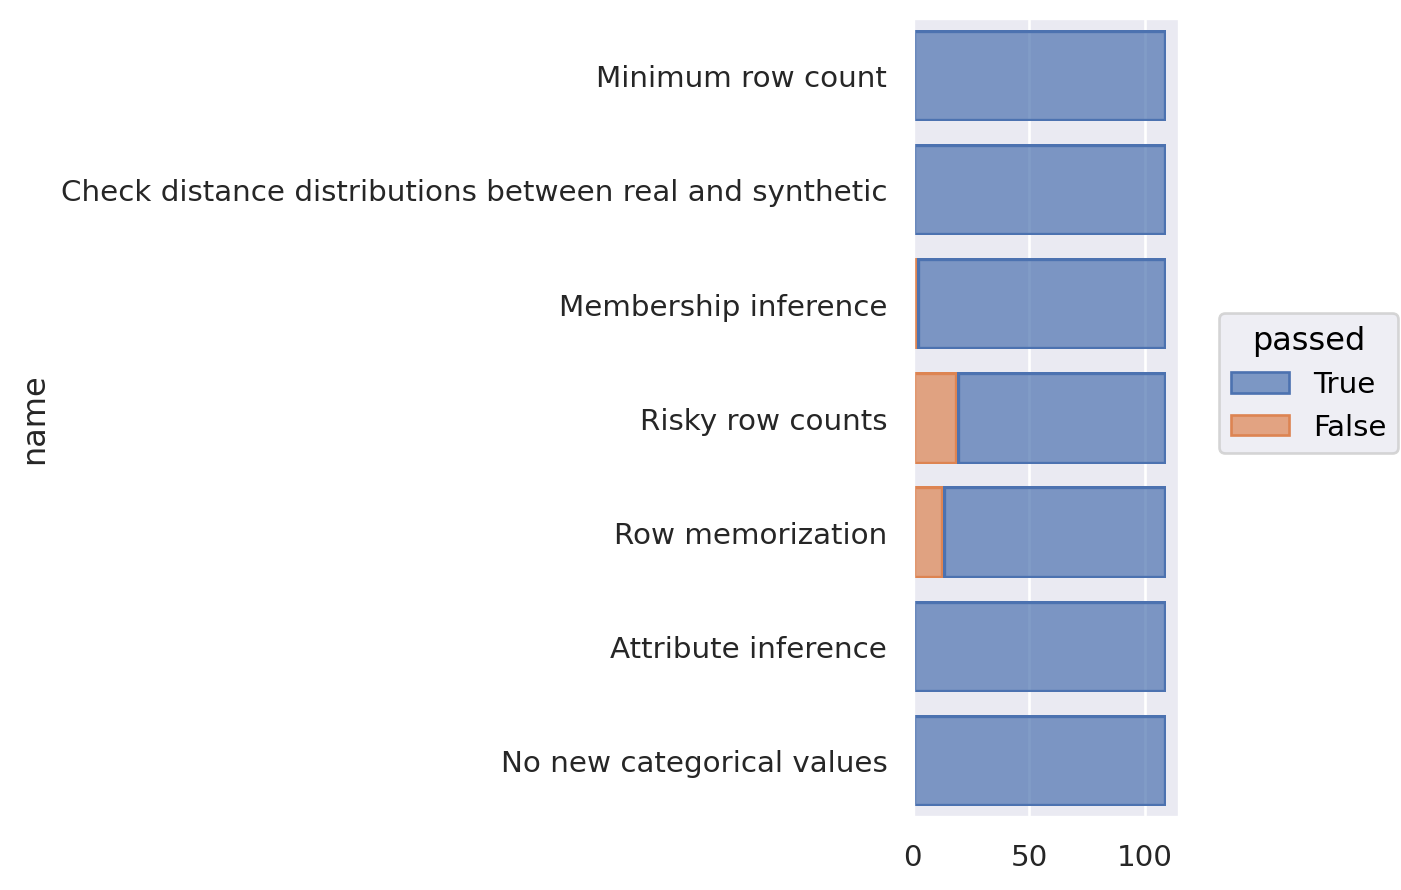

In [21]:
import seaborn.objects as so
import seaborn as sns
import matplotlib.pyplot as plt

so.Plot(df, y="name", color="passed").add(so.Bar(), so.Count(), so.Stack())

In [22]:
# Filter the DataFrame to include only rows where 'name' is in the list of failed names
df_hasfail = df[df["name"].isin(df[df["passed"] == False]["name"].unique().tolist())]

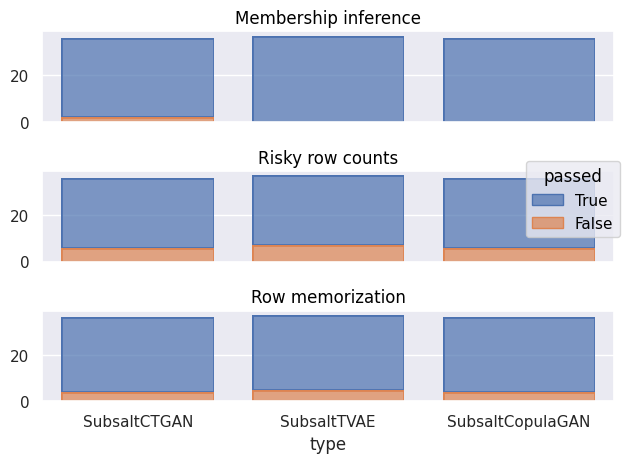

In [23]:
import seaborn.objects as so

plot = (
    so.Plot(df_hasfail, x="type", color="passed").facet(row="name")
    # add stacked bars and histogram
    .add(so.Bar(), so.Count(), so.Stack())
)
plot.show()

* Based on the sample data showed above, the privacy tests fail more likely are `Risky row counts`, `Membership inference`, `Row memorization`.

In [24]:
df_failed = df[df["passed"] == False]
df_failed

,type,epochs,learning_rate,batch_size,row_count,table_names,schema_id,num_variables,num_indirect_identifier,num_categorical,num_i_identifier_categorical,num_high_unique_values_categorical,mean_unique_values_categorical,train_row_count,name,threshold,score,passed
3,SubsaltCTGAN,100,0.0002,50000,12960,nursery,0,10.0,9.0,8.0,8.0,0.0,3.750000,12960,Risky row counts,123.12,2575.000000,False
4,SubsaltCTGAN,100,0.0002,50000,12960,nursery,0,10.0,9.0,8.0,8.0,0.0,3.750000,12960,Row memorization,0.05,0.325211,False
31,SubsaltCopulaGAN,100,0.0002,50000,12960,nursery,0,10.0,9.0,8.0,8.0,0.0,3.750000,12960,Risky row counts,123.12,2617.000000,False
32,SubsaltCopulaGAN,100,0.0002,50000,12960,nursery,0,10.0,9.0,8.0,8.0,0.0,3.750000,12960,Row memorization,0.05,0.325292,False
37,SubsaltTVAE,100,0.0002,50000,12960,nursery,0,10.0,9.0,8.0,8.0,0.0,3.750000,12960,Risky row counts,123.12,2821.000000,False
39,SubsaltTVAE,100,0.0002,50000,12960,nursery,0,10.0,9.0,8.0,8.0,0.0,3.750000,12960,Row memorization,0.05,0.688596,False
170,SubsaltTVAE,100,0.0002,50000,12960,nursery,7,10.0,7.0,8.0,7.0,0.0,3.750000,12960,Risky row counts,123.12,638.000000,False
178,SubsaltCopulaGAN,100,0.0002,50000,12960,nursery,7,10.0,7.0,8.0,7.0,0.0,3.750000,12960,Risky row counts,123.12,673.000000,False
185,SubsaltCTGAN,100,0.0002,50000,12960,nursery,7,10.0,7.0,8.0,7.0,0.0,3.750000,12960,Risky row counts,123.12,744.000000,False
289,SubsaltCTGAN,100,0.0002,50000,100000,healthcare_dataset,13,12.0,11.0,3.0,3.0,1.0,6.333333,100000,Membership inference,0.55,0.569136,False


In [25]:
df_failed.groupby("name")["type"].value_counts()

name                  type            
Membership inference  SubsaltCTGAN        2
Risky row counts      SubsaltTVAE         7
                      SubsaltCTGAN        6
                      SubsaltCopulaGAN    6
Row memorization      SubsaltTVAE         5
                      SubsaltCTGAN        4
                      SubsaltCopulaGAN    4
Name: count, dtype: int64

In [26]:
df.groupby("name")["type"].value_counts()

name                                                     type            
Attribute inference                                      SubsaltTVAE         37
                                                         SubsaltCTGAN        36
                                                         SubsaltCopulaGAN    36
Check distance distributions between real and synthetic  SubsaltTVAE         37
                                                         SubsaltCTGAN        36
                                                         SubsaltCopulaGAN    36
Membership inference                                     SubsaltTVAE         37
                                                         SubsaltCTGAN        36
                                                         SubsaltCopulaGAN    36
Minimum row count                                        SubsaltTVAE         37
                                                         SubsaltCTGAN        36
                                                         SubsaltCopulaGAN    36
No new categorical values                                SubsaltTVAE         37
                                                         SubsaltCTGAN        36
                                                         SubsaltCopulaGAN    36
Risky row counts                                         SubsaltTVAE         37
                                                         SubsaltCTGAN        36
                                                         SubsaltCopulaGAN    36
Row memorization                                         SubsaltTVAE         37
                                                         SubsaltCTGAN        36
                                                         SubsaltCopulaGAN    36
Name: count, dtype: int64

In [27]:
for table_names in df_failed["table_names"].unique():
    for name in df_failed[df_failed["table_names"] == table_names]["name"].unique():
        for type in df_failed[df_failed["table_names"] == table_names]["type"].unique():
            print(f"table names: {table_names}, Privacy test: {name}, Type: {type}")
            print(
                df[
                    (df["table_names"] == table_names)
                    & (df["name"] == name)
                    & (df["type"] == type)
                ][
                    [
                        # "type",
                        "epochs",
                        "row_count",
                        "passed",
                        "schema_id",
                        "score",
                        "threshold",
                    ]
                ]
            )

table names: nursery, Privacy test: Risky row counts, Type: SubsaltCTGAN
    epochs  row_count  passed  schema_id   score  threshold
3      100      12960   False          0  2575.0     123.12
24     100      12960    True          1     0.0     123.12
59     100      12960    True          2     0.0     123.12
73     100      12960    True          3     0.0     123.12
87     100      12960    True          4     0.0     123.12
107    100      12960    True          2     0.0     123.12
143    100      12960    True          5     4.0     123.12
157    100      12960    True          6     0.0     123.12
185    100      12960   False          7   744.0     123.12
table names: nursery, Privacy test: Risky row counts, Type: SubsaltCopulaGAN
    epochs  row_count  passed  schema_id   score  threshold
17     100      12960    True          1     0.0     123.12
31     100      12960   False          0  2617.0     123.12
51     100      12960    True          2     0.0     123.12
93     100

In [28]:
df["ratio_indirect_identifier"] = df["num_indirect_identifier"] / df["num_variables"]
df["ratio_categorical"] = df["num_categorical"] / df["num_variables"]
df["ratio_i_identifier_categorical"] = (
    df["num_i_identifier_categorical"] / df["num_variables"]
)

In [29]:
df[
    (df["table_names"] == "applications")
    & (df["schema_id"] == 19)
    & (df["name"] == "Row memorization")
]

,type,epochs,learning_rate,batch_size,row_count,table_names,schema_id,num_variables,num_indirect_identifier,num_categorical,...,num_high_unique_values_categorical,mean_unique_values_categorical,train_row_count,name,threshold,score,passed,ratio_indirect_identifier,ratio_categorical,ratio_i_identifier_categorical
416,SubsaltCTGAN,100,0.0002,50000,250000,applications,19,11.0,10.0,7.0,...,4.0,11.285714,250000,Row memorization,0.05,0.011697,True,0.909091,0.636364,0.636364
430,SubsaltCopulaGAN,100,0.0002,50000,250000,applications,19,11.0,10.0,7.0,...,4.0,11.285714,250000,Row memorization,0.05,0.012474,True,0.909091,0.636364,0.636364
460,SubsaltTVAE,100,0.0002,50000,250000,applications,19,11.0,10.0,7.0,...,4.0,11.285714,250000,Row memorization,0.05,0.325583,False,0.909091,0.636364,0.636364
473,SubsaltTVAE,100,0.0002,50000,1000000,applications,19,11.0,10.0,7.0,...,4.0,11.285714,400000,Row memorization,0.05,0.661578,False,0.909091,0.636364,0.636364
480,SubsaltCTGAN,100,0.0002,50000,1000000,applications,19,11.0,10.0,7.0,...,4.0,11.285714,400000,Row memorization,0.05,0.136133,False,0.909091,0.636364,0.636364
487,SubsaltCopulaGAN,100,0.0002,50000,1000000,applications,19,11.0,10.0,7.0,...,4.0,11.285714,400000,Row memorization,0.05,0.154327,False,0.909091,0.636364,0.636364


In [30]:
df_schema[(df_schema["table_names"] == "applications") & (df_schema["schema_id"] == 19)]

,name,type,synthesize_as,indirect_identifier,direct_identifier,null_ratio,unique_values,min_value,max_value,schema_id,table_names
0,agency_abbr,SubsaltCTGAN,categorical,True,False,0.00000,6.0,NaN,NaN,19,applications
1,loan_type_name,SubsaltCTGAN,categorical,True,False,0.00000,4.0,NaN,NaN,19,applications
2,property_type_name,SubsaltCTGAN,categorical,True,False,0.00000,3.0,NaN,NaN,19,applications
3,loan_amount_000s,SubsaltCTGAN,int,True,False,0.00052,1203.0,1.0,20000.0,19,applications
4,action_taken_name,SubsaltCTGAN,categorical,True,False,0.00000,8.0,NaN,NaN,19,applications
...,...,...,...,...,...,...,...,...,...,...,...
6,applicant_ethnicity,SubsaltCopulaGAN,categorical,True,False,0.00000,4.0,1.0,4.0,19,applications
7,applicant_race_1,SubsaltCopulaGAN,categorical,True,False,0.00000,7.0,1.0,7.0,19,applications
8,population,SubsaltCopulaGAN,int,True,False,0.00464,6053.0,0.0,53812.0,19,applications
9,hud_median_family_income,SubsaltCopulaGAN,int,True,False,0.00464,241.0,37900.0,114200.0,19,applications


In [31]:
df.head()

,type,epochs,learning_rate,batch_size,row_count,table_names,schema_id,num_variables,num_indirect_identifier,num_categorical,...,num_high_unique_values_categorical,mean_unique_values_categorical,train_row_count,name,threshold,score,passed,ratio_indirect_identifier,ratio_categorical,ratio_i_identifier_categorical
0,SubsaltCTGAN,100,0.0002,50000,12960,nursery,0,10.0,9.0,8.0,...,0.0,3.75,12960,Minimum row count,3000.00,12960.000000,True,0.9,0.8,0.8
1,SubsaltCTGAN,100,0.0002,50000,12960,nursery,0,10.0,9.0,8.0,...,0.0,3.75,12960,Check distance distributions between real and ...,0.05,0.331952,True,0.9,0.8,0.8
2,SubsaltCTGAN,100,0.0002,50000,12960,nursery,0,10.0,9.0,8.0,...,0.0,3.75,12960,Membership inference,0.55,0.506659,True,0.9,0.8,0.8
3,SubsaltCTGAN,100,0.0002,50000,12960,nursery,0,10.0,9.0,8.0,...,0.0,3.75,12960,Risky row counts,123.12,2575.000000,False,0.9,0.8,0.8
4,SubsaltCTGAN,100,0.0002,50000,12960,nursery,0,10.0,9.0,8.0,...,0.0,3.75,12960,Row memorization,0.05,0.325211,False,0.9,0.8,0.8


* Create subset of data for three target privacy tests.

In [32]:
# change epochs to integer
df["epochs"] = df["epochs"].astype(int)
df["passed"] = pd.Categorical(df["passed"]).codes

In [33]:
df_risky_row_counts = df[df["name"] == "Risky row counts"]

In [34]:
df_row_memorization = df[df["name"] == "Row memorization"]

In [35]:
df_membership_inference = df[df["name"] == "Membership inference"]

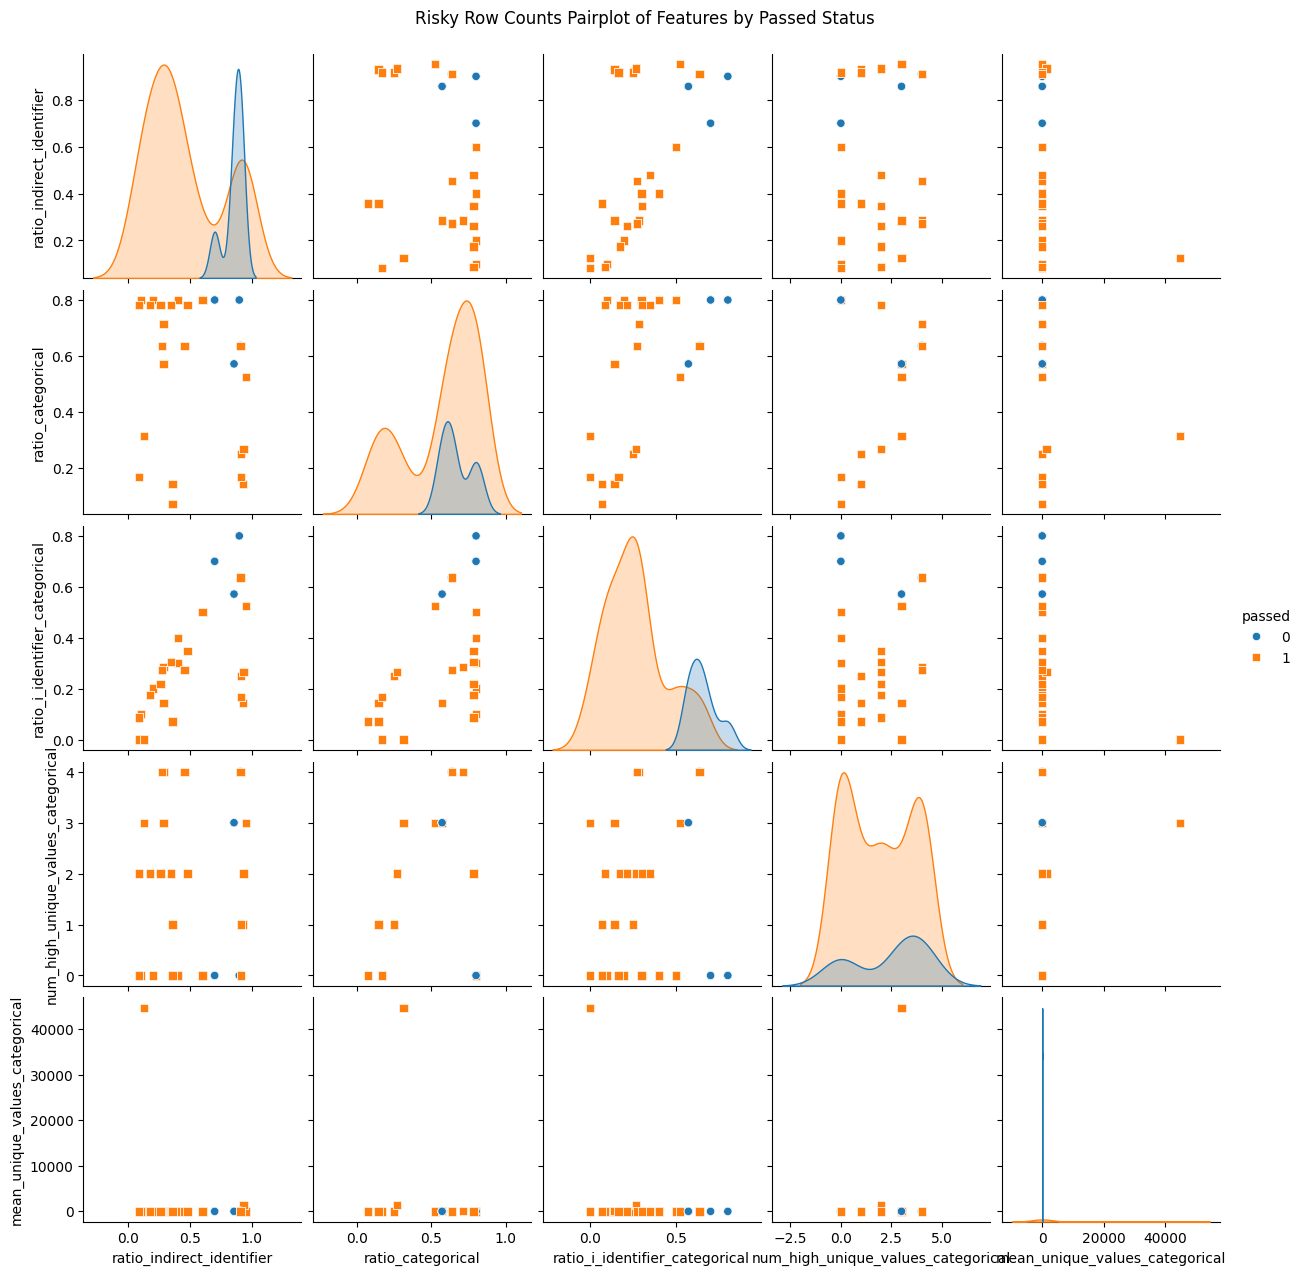

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

plot = sns.pairplot(
    df_risky_row_counts,
    x_vars=[
        "ratio_indirect_identifier",
        "ratio_categorical",
        "ratio_i_identifier_categorical",
        "num_high_unique_values_categorical",
        "mean_unique_values_categorical",
    ],
    y_vars=[
        "ratio_indirect_identifier",
        "ratio_categorical",
        "ratio_i_identifier_categorical",
        "num_high_unique_values_categorical",
        "mean_unique_values_categorical",
    ],
    hue="passed",
    markers=["o", "s"],
)
plot.fig.suptitle("Risky Row Counts Pairplot of Features by Passed Status", y=1.02)
plt.show()

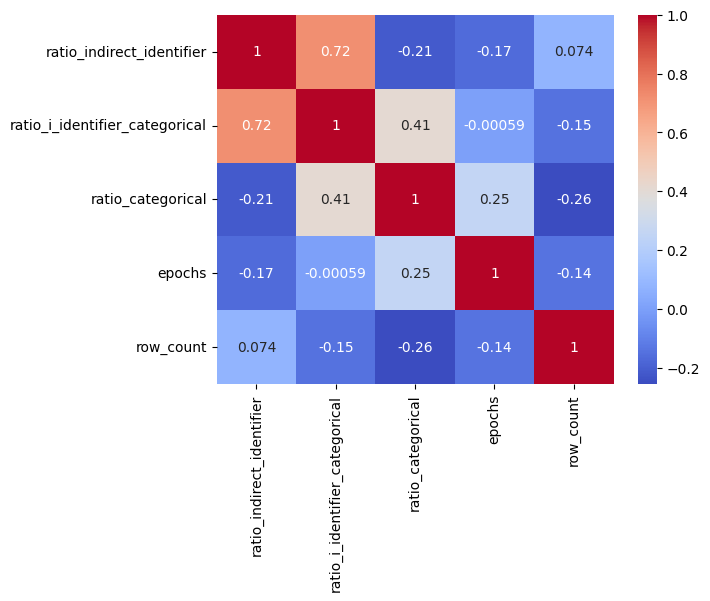

In [37]:
import matplotlib.pyplot as plt

# Check for multicollinearity
corr_matrix = df_risky_row_counts[
    [
        "ratio_indirect_identifier",
        "ratio_i_identifier_categorical",
        "ratio_categorical",
        "epochs",
        "row_count",
    ]
].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

In [38]:
df_risky_row_counts["passed"].value_counts()

,count
passed,
1,90
0,19


In [39]:
dedup_df_risky_row_counts = df_risky_row_counts[
    ["ratio_i_identifier_categorical", "epochs", "row_count", "type", "passed"]
]
dedup_df_risky_row_counts.drop_duplicates(inplace=True)
dedup_df_risky_row_counts.passed.value_counts()

,count
passed,
1,78
0,16


In [40]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    auc,
    accuracy_score,
    f1_score,
)

# Select numerical features
X = dedup_df_risky_row_counts[["ratio_i_identifier_categorical", "epochs", "row_count"]]
y = dedup_df_risky_row_counts["passed"]

# One-hot encode the categorical feature 'type'
encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded_type = encoder.fit_transform(dedup_df_risky_row_counts[["type"]])

# Convert the encoded array to a DataFrame
encoded_type_df = pd.DataFrame(
    encoded_type, columns=encoder.get_feature_names_out(["type"])
)

# Concatenate the encoded categorical feature with the existing features
X = pd.concat(
    [X.reset_index(drop=True), encoded_type_df.reset_index(drop=True)], axis=1
)

# Initialize logistic regression and cross-validation
model = LogisticRegression(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Metrics storage
pr_auc_scores = []
accuracy_scores = []
f1_scores = []

# Cross-validation loop
for train_idx, test_idx in cv.split(X, y):
    # Split data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train the model
    model.fit(X_train, y_train)

    # Predict probabilities and labels
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    # PR-AUC
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    pr_auc = auc(recall, precision)
    pr_auc_scores.append(pr_auc)

    # Accuracy
    accuracy_scores.append(accuracy_score(y_test, y_pred))

    # F1 Score
    f1_scores.append(f1_score(y_test, y_pred))

# Print mean and variability for each metric
print(
    f"Mean PR-AUC: {sum(pr_auc_scores) / len(pr_auc_scores):.2f} +/- {(max(pr_auc_scores) - min(pr_auc_scores)):.2f}"
)
print(
    f"Mean Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f} +/- {(max(accuracy_scores) - min(accuracy_scores)):.2f}"
)
print(
    f"Mean F1 Score: {sum(f1_scores) / len(f1_scores):.2f} +/- {(max(f1_scores) - min(f1_scores)):.2f}"
)

Mean PR-AUC: 0.96 +/- 0.10
Mean Accuracy: 0.83 +/- 0.05
Mean F1 Score: 0.91 +/- 0.03


In [41]:
dedup_df_risky_row_counts = df_risky_row_counts[
    [
        "ratio_indirect_identifier",
        "ratio_categorical",
        "epochs",
        "row_count",
        "type",
        "passed",
    ]
]
dedup_df_risky_row_counts.drop_duplicates(inplace=True)
dedup_df_risky_row_counts.passed.value_counts()

,count
passed,
1,78
0,16


In [42]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
import pandas as pd

# Select numerical features
X = dedup_df_risky_row_counts[
    ["ratio_indirect_identifier", "ratio_categorical", "epochs", "row_count"]
]
y = dedup_df_risky_row_counts["passed"]

# One-hot encode the categorical feature 'type'
encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded_type = encoder.fit_transform(dedup_df_risky_row_counts[["type"]])

# Convert the encoded array to a DataFrame
encoded_type_df = pd.DataFrame(
    encoded_type, columns=encoder.get_feature_names_out(["type"])
)

# Concatenate the encoded categorical feature with the existing features
X = pd.concat(
    [X.reset_index(drop=True), encoded_type_df.reset_index(drop=True)], axis=1
)

# Initialize logistic regression and cross-validation
model = LogisticRegression(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Metrics storage
pr_auc_scores = []
accuracy_scores = []
f1_scores = []

# Cross-validation loop
for train_idx, test_idx in cv.split(X, y):
    # Split data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train the model
    model.fit(X_train, y_train)

    # Predict probabilities and labels
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    # PR-AUC
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    pr_auc = auc(recall, precision)
    pr_auc_scores.append(pr_auc)

    # Accuracy
    accuracy_scores.append(accuracy_score(y_test, y_pred))

    # F1 Score
    f1_scores.append(f1_score(y_test, y_pred))

# Print mean and variability for each metric
print(
    f"Mean PR-AUC: {sum(pr_auc_scores) / len(pr_auc_scores):.2f} +/- {(max(pr_auc_scores) - min(pr_auc_scores)):.2f}"
)
print(
    f"Mean Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f} +/- {(max(accuracy_scores) - min(accuracy_scores)):.2f}"
)
print(
    f"Mean F1 Score: {sum(f1_scores) / len(f1_scores):.2f} +/- {(max(f1_scores) - min(f1_scores)):.2f}"
)

Mean PR-AUC: 0.92 +/- 0.12
Mean Accuracy: 0.81 +/- 0.11
Mean F1 Score: 0.89 +/- 0.07


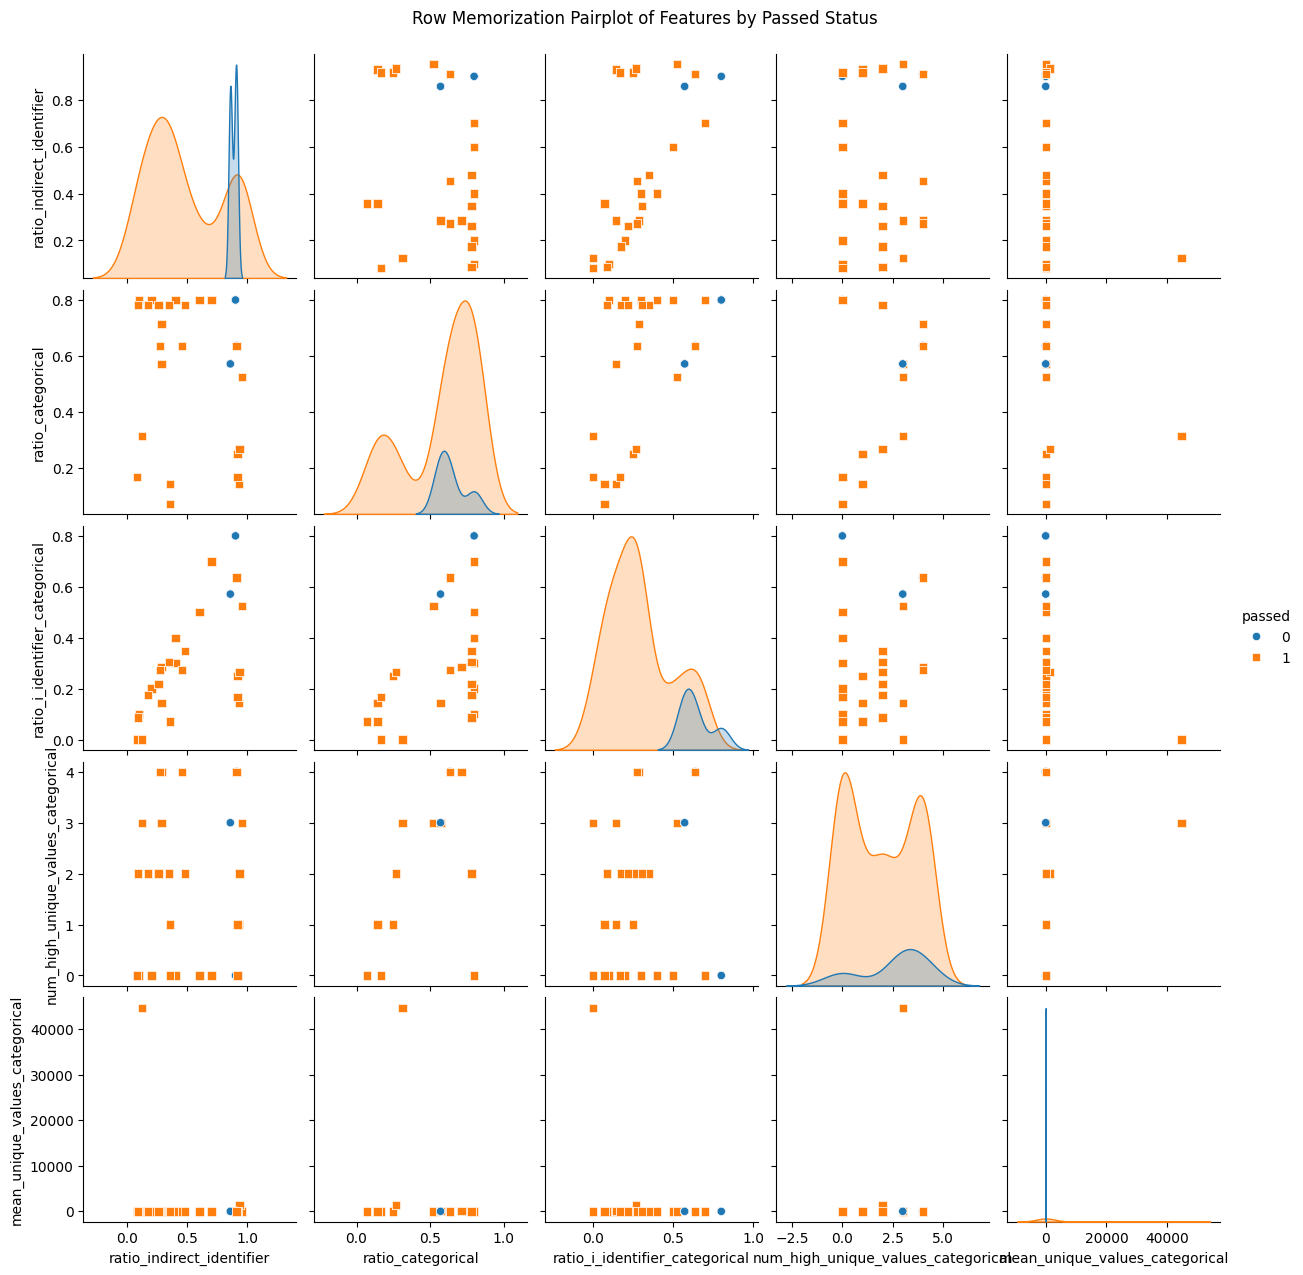

In [43]:
import seaborn as sns

plot = sns.pairplot(
    df_row_memorization,
    x_vars=[
        "ratio_indirect_identifier",
        "ratio_categorical",
        "ratio_i_identifier_categorical",
        "num_high_unique_values_categorical",
        "mean_unique_values_categorical",
    ],
    y_vars=[
        "ratio_indirect_identifier",
        "ratio_categorical",
        "ratio_i_identifier_categorical",
        "num_high_unique_values_categorical",
        "mean_unique_values_categorical",
    ],
    hue="passed",
    markers=["o", "s"],
)
plot.fig.suptitle("Row Memorization Pairplot of Features by Passed Status", y=1.02)
plt.show()

In [44]:
df_row_memorization["passed"].value_counts()

,count
passed,
1,96
0,13


In [45]:
dedup_df_row_memorization = df_row_memorization[
    ["ratio_i_identifier_categorical", "epochs", "row_count", "type", "passed"]
]
dedup_df_row_memorization.drop_duplicates(inplace=True)
dedup_df_row_memorization.passed.value_counts()

,count
passed,
1,84
0,10


In [46]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
import pandas as pd

# Select numerical features
X = dedup_df_row_memorization[["ratio_i_identifier_categorical", "epochs", "row_count"]]
y = dedup_df_row_memorization["passed"]

# One-hot encode the categorical feature 'type'
encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded_type = encoder.fit_transform(dedup_df_row_memorization[["type"]])

# Convert the encoded array to a DataFrame
encoded_type_df = pd.DataFrame(
    encoded_type, columns=encoder.get_feature_names_out(["type"])
)

# Concatenate the encoded categorical feature with the existing features
X = pd.concat(
    [X.reset_index(drop=True), encoded_type_df.reset_index(drop=True)], axis=1
)

# Initialize logistic regression and cross-validation
model = LogisticRegression(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Metrics storage
pr_auc_scores = []
accuracy_scores = []
f1_scores = []

# Cross-validation loop
for train_idx, test_idx in cv.split(X, y):
    # Split data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train the model
    model.fit(X_train, y_train)

    # Predict probabilities and labels
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    # PR-AUC
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    pr_auc = auc(recall, precision)
    pr_auc_scores.append(pr_auc)

    # Accuracy
    accuracy_scores.append(accuracy_score(y_test, y_pred))

    # F1 Score
    f1_scores.append(f1_score(y_test, y_pred))

# Print mean and variability for each metric
print(
    f"Mean PR-AUC: {sum(pr_auc_scores) / len(pr_auc_scores):.2f} +/- {(max(pr_auc_scores) - min(pr_auc_scores)):.2f}"
)
print(
    f"Mean Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f} +/- {(max(accuracy_scores) - min(accuracy_scores)):.2f}"
)
print(
    f"Mean F1 Score: {sum(f1_scores) / len(f1_scores):.2f} +/- {(max(f1_scores) - min(f1_scores)):.2f}"
)

Mean PR-AUC: 0.96 +/- 0.04
Mean Accuracy: 0.89 +/- 0.01
Mean F1 Score: 0.94 +/- 0.00


In [47]:
dedup_df_row_memorization = df_row_memorization[
    [
        "ratio_indirect_identifier",
        "ratio_categorical",
        "epochs",
        "row_count",
        "type",
        "passed",
    ]
]
dedup_df_row_memorization.drop_duplicates(inplace=True)
dedup_df_row_memorization.passed.value_counts()

,count
passed,
1,84
0,10


In [48]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    auc,
    accuracy_score,
    f1_score,
)

# Prepare features and labels
X = dedup_df_row_memorization[
    ["ratio_indirect_identifier", "ratio_categorical", "epochs", "row_count"]
]
y = dedup_df_row_memorization["passed"]

# One-hot encode the categorical feature 'type'
encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded_type = encoder.fit_transform(dedup_df_row_memorization[["type"]])

# Convert the encoded array to a DataFrame
encoded_type_df = pd.DataFrame(
    encoded_type, columns=encoder.get_feature_names_out(["type"])
)

# Concatenate the encoded categorical feature with the existing features
X = pd.concat(
    [X.reset_index(drop=True), encoded_type_df.reset_index(drop=True)], axis=1
)

# Initialize logistic regression and cross-validation
model = LogisticRegression(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Metrics storage
pr_auc_scores = []
accuracy_scores = []
f1_scores = []

# Cross-validation loop
for train_idx, test_idx in cv.split(X, y):
    # Split data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train the model
    model.fit(X_train, y_train)

    # Predict probabilities and labels
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    # PR-AUC
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    pr_auc = auc(recall, precision)
    pr_auc_scores.append(pr_auc)

    # Accuracy
    accuracy_scores.append(accuracy_score(y_test, y_pred))

    # F1 Score
    f1_scores.append(f1_score(y_test, y_pred))

# Print mean and variability for each metric
print(
    f"Mean PR-AUC: {sum(pr_auc_scores) / len(pr_auc_scores):.2f} +/- {(max(pr_auc_scores) - min(pr_auc_scores)):.2f}"
)
print(
    f"Mean Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f} +/- {(max(accuracy_scores) - min(accuracy_scores)):.2f}"
)
print(
    f"Mean F1 Score: {sum(f1_scores) / len(f1_scores):.2f} +/- {(max(f1_scores) - min(f1_scores)):.2f}"
)

Mean PR-AUC: 0.94 +/- 0.06
Mean Accuracy: 0.89 +/- 0.01
Mean F1 Score: 0.94 +/- 0.00


SHAP

Risky Row Counts

1. Holistic SHAP Analysis (Second Dataset)

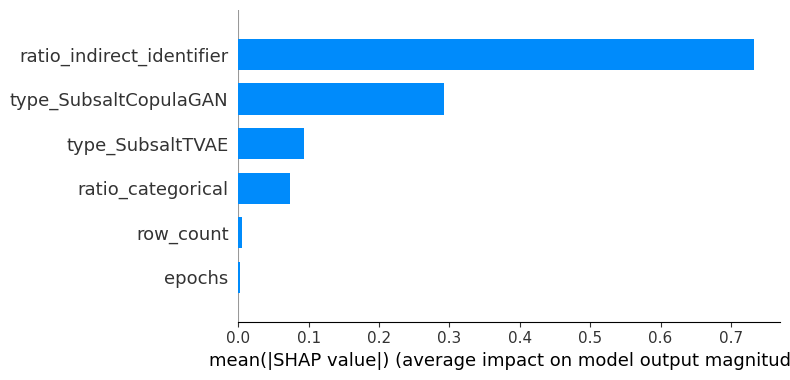

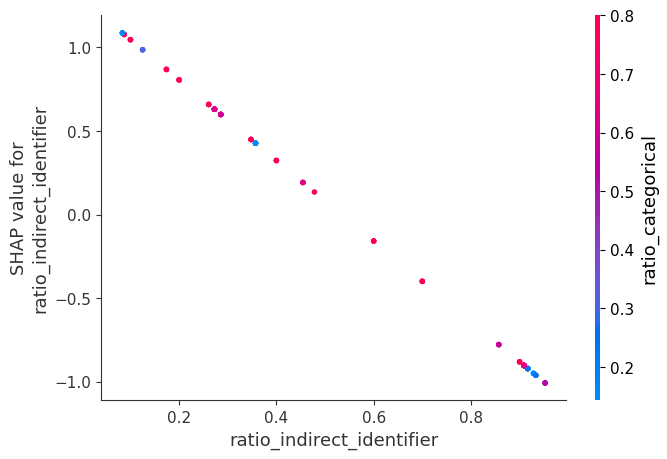

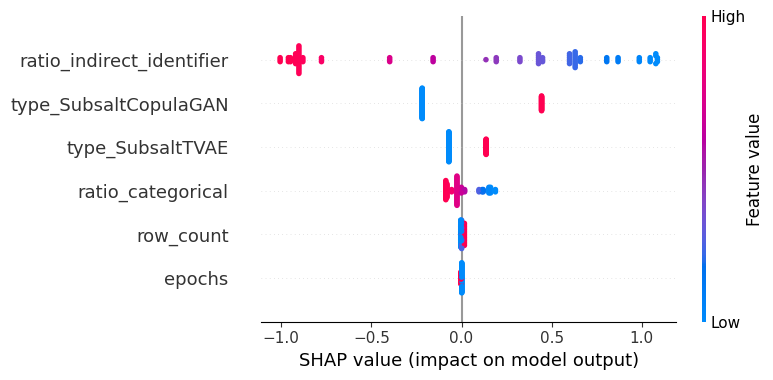

In [49]:
import shap
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt

# Select numerical features
X = dedup_df_risky_row_counts[["ratio_indirect_identifier", "ratio_categorical", "epochs", "row_count"]]
y = dedup_df_risky_row_counts["passed"]

# One-hot encode the categorical feature 'type'
encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded_type = encoder.fit_transform(dedup_df_risky_row_counts[["type"]])

# Convert the encoded array to a DataFrame
encoded_type_df = pd.DataFrame(encoded_type, columns=encoder.get_feature_names_out(["type"]))

# Concatenate the encoded categorical feature with the existing features
X = pd.concat([X.reset_index(drop=True), encoded_type_df.reset_index(drop=True)], axis=1)

# Initialize logistic regression model
model = LogisticRegression(random_state=42)

# Train the model on the entire dataset for SHAP explanation
model.fit(X, y)

# Create a SHAP explainer for the logistic regression model
explainer = shap.Explainer(model, X)

# Compute SHAP values for the dataset
shap_values = explainer(X)

# Plot the SHAP summary plot with interaction effects
shap.summary_plot(shap_values, X, plot_type="bar")

# To examine interactions, you can use SHAP interaction values for specific feature pairs
# SHAP interaction values will give insight into how two features interact

# Example: Interaction between `ratio_indirect_identifier` and `ratio_categorical`
shap_interaction_values = explainer.shap_values(X)

# Plot the interaction between the two specific features
shap.dependence_plot(
    ind="ratio_indirect_identifier",
    shap_values=shap_interaction_values,
    features=X,
    interaction_index="ratio_categorical"
)

# You can also visualize a general interaction plot for the top feature combinations
shap.summary_plot(shap_values, X)  # This will show the summary for all features


In [50]:
import shap
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt

# Select numerical features
X = dedup_df_risky_row_counts[["ratio_indirect_identifier", "ratio_categorical", "epochs", "row_count"]]
y = dedup_df_risky_row_counts["passed"]

# One-hot encode the categorical feature 'type'
encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded_type = encoder.fit_transform(dedup_df_risky_row_counts[["type"]])

# Convert the encoded array to a DataFrame
encoded_type_df = pd.DataFrame(encoded_type, columns=encoder.get_feature_names_out(["type"]))

# Concatenate the encoded categorical feature with the existing features
X = pd.concat([X.reset_index(drop=True), encoded_type_df.reset_index(drop=True)], axis=1)

# Initialize logistic regression model
model = LogisticRegression(random_state=42)

# Train the model on the entire dataset for SHAP explanation
model.fit(X, y)

# Create a SHAP explainer for the logistic regression model
explainer = shap.Explainer(model, X)

# Compute SHAP values for the dataset
shap_values = explainer(X)

# Extract SHAP interaction values
shap_interaction_values = shap_values[:, ["ratio_indirect_identifier", "ratio_categorical"]].values

# Convert the interaction values to a DataFrame for easier inspection
interaction_df = pd.DataFrame(shap_interaction_values, columns=["ratio_indirect_identifier_interaction", "ratio_categorical_interaction"])

# Combine with the original features to analyze
interaction_df["ratio_indirect_identifier"] = X["ratio_indirect_identifier"]
interaction_df["ratio_categorical"] = X["ratio_categorical"]

# Display the interaction values DataFrame
print(interaction_df)


    ratio_indirect_identifier_interaction  ratio_categorical_interaction  \
0                               -0.880449                      -0.087315   
1                                0.805525                      -0.087315   
2                                0.805525                      -0.087315   
3                                0.805525                      -0.087315   
4                               -0.880449                      -0.087315   
..                                    ...                            ...   
89                               0.427041                       0.160751   
90                               0.427041                       0.160751   
91                              -0.902345                      -0.025544   
92                              -0.902345                      -0.025544   
93                              -0.902345                      -0.025544   

    ratio_indirect_identifier  ratio_categorical  
0                    0.900000       

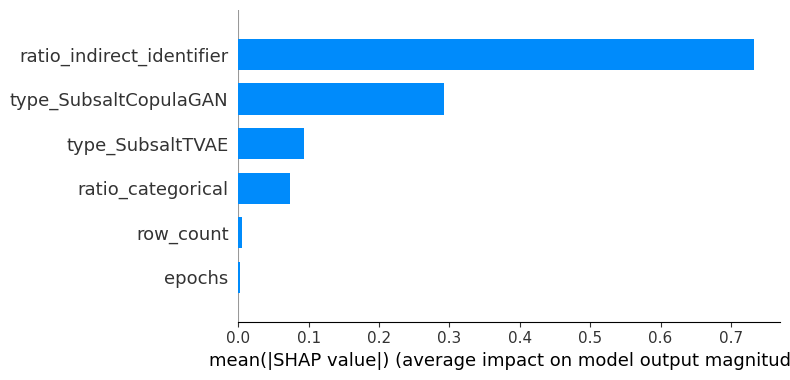

In [51]:
import shap
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt

# Select numerical features
X = dedup_df_risky_row_counts[["ratio_indirect_identifier", "ratio_categorical", "epochs", "row_count"]]
y = dedup_df_risky_row_counts["passed"]

# One-hot encode the categorical feature 'type'
encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded_type = encoder.fit_transform(dedup_df_risky_row_counts[["type"]])

# Convert the encoded array to a DataFrame
encoded_type_df = pd.DataFrame(encoded_type, columns=encoder.get_feature_names_out(["type"]))

# Concatenate the encoded categorical feature with the existing features
X = pd.concat([X.reset_index(drop=True), encoded_type_df.reset_index(drop=True)], axis=1)

# Initialize logistic regression model
model = LogisticRegression(random_state=42)

# Train the model on the entire dataset for SHAP explanation
model.fit(X, y)

# Create a SHAP explainer for the logistic regression model
explainer = shap.Explainer(model, X)

# Compute SHAP values for the dataset
shap_values = explainer(X)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X, plot_type="bar")

# Optionally, you can also plot a detailed SHAP summary plot
# shap.summary_plot(shap_values, X)




In [52]:
import pandas as pd

# Get SHAP values
shap_values_array = shap_values.values

# Create a DataFrame to show the SHAP values for each feature and instance
shap_values_df = pd.DataFrame(shap_values_array, columns=X.columns)
print(shap_values_df)

    ratio_indirect_identifier  ratio_categorical    epochs  row_count  \
0                   -0.880449          -0.087315  0.001213  -0.004361   
1                    0.805525          -0.087315  0.001213  -0.004361   
2                    0.805525          -0.087315  0.001213  -0.004361   
3                    0.805525          -0.087315  0.001213  -0.004361   
4                   -0.880449          -0.087315  0.001213  -0.004361   
..                        ...                ...       ...        ...   
89                   0.427041           0.160751  0.001213  -0.004524   
90                   0.427041           0.160751  0.001213  -0.004524   
91                  -0.902345          -0.025544  0.000297  -0.004115   
92                  -0.902345          -0.025544  0.000297  -0.004115   
93                  -0.902345          -0.025544  0.000297  -0.004115   

    type_SubsaltCopulaGAN  type_SubsaltTVAE  
0               -0.218435         -0.070299  
1               -0.218435      

In [53]:
shap_values_df

,ratio_indirect_identifier,ratio_categorical,epochs,row_count,type_SubsaltCopulaGAN,type_SubsaltTVAE
0,-0.880449,-0.087315,0.001213,-0.004361,-0.218435,-0.070299
1,0.805525,-0.087315,0.001213,-0.004361,-0.218435,0.136204
2,0.805525,-0.087315,0.001213,-0.004361,0.443917,-0.070299
3,0.805525,-0.087315,0.001213,-0.004361,-0.218435,-0.070299
4,-0.880449,-0.087315,0.001213,-0.004361,0.443917,-0.070299
...,...,...,...,...,...,...
89,0.427041,0.160751,0.001213,-0.004524,-0.218435,0.136204
90,0.427041,0.160751,0.001213,-0.004524,0.443917,-0.070299
91,-0.902345,-0.025544,0.000297,-0.004115,-0.218435,0.136204
92,-0.902345,-0.025544,0.000297,-0.004115,-0.218435,-0.070299


Absolute Values

In [54]:
feature_contributions = shap_values_df.sum()
print(feature_contributions)


ratio_indirect_identifier   -4.329870e-14
ratio_categorical           -4.433953e-15
epochs                       5.323433e-17
row_count                    7.459311e-17
type_SubsaltCopulaGAN        1.998401e-15
type_SubsaltTVAE            -4.163336e-16
dtype: float64


Relative Impact

In [55]:
shap_values = [-4.174439e-14, -2.754741e-15, -4.228388e-17, -1.613293e-16, 1.831868e-15, -6.106227e-16]
total_sum = 4.620367e-14

for value in shap_values:
    normalized_value = abs(value) / total_sum
    print(f"{normalized_value:.10f}")

0.9034864546
0.0596216924
0.0009151628
0.0034916988
0.0396476730
0.0132158917


Row Memorization

In [56]:
dedup_df_row_memorization = df_row_memorization[
    ["ratio_i_identifier_categorical", "ratio_indirect_identifier", "ratio_categorical", "epochs", "row_count","type","passed"]
]
dedup_df_row_memorization.drop_duplicates(inplace=True)
dedup_df_row_memorization.passed.value_counts()

,count
passed,
1,87
0,10


In [57]:
dedup_df_row_memorization

,ratio_i_identifier_categorical,ratio_indirect_identifier,ratio_categorical,epochs,row_count,type,passed
4,0.800000,0.900000,0.800000,100,12960,SubsaltCTGAN,0
11,0.200000,0.200000,0.800000,100,12960,SubsaltTVAE,1
18,0.200000,0.200000,0.800000,100,12960,SubsaltCopulaGAN,1
25,0.200000,0.200000,0.800000,100,12960,SubsaltCTGAN,1
32,0.800000,0.900000,0.800000,100,12960,SubsaltCopulaGAN,0
...,...,...,...,...,...,...,...
732,0.071429,0.357143,0.142857,100,5000,SubsaltTVAE,1
739,0.071429,0.357143,0.142857,100,5000,SubsaltCopulaGAN,1
747,0.636364,0.909091,0.636364,300,25000,SubsaltTVAE,1
753,0.636364,0.909091,0.636364,300,25000,SubsaltCTGAN,1


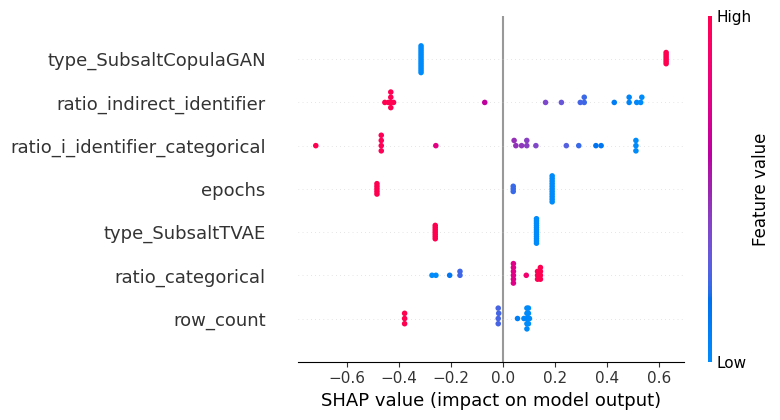

In [58]:
import pandas as pd
import shap
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    auc,
    accuracy_score,
    f1_score,
)

# Prepare features and labels
X = dedup_df_row_memorization[[ "ratio_i_identifier_categorical","ratio_indirect_identifier", "ratio_categorical", "epochs", "row_count"]]
y = dedup_df_row_memorization["passed"]

# One-hot encode the categorical feature 'type'
encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded_type = encoder.fit_transform(dedup_df_row_memorization[["type"]])

# Convert the encoded array to a DataFrame
encoded_type_df = pd.DataFrame(
    encoded_type, columns=encoder.get_feature_names_out(["type"])
)

# Concatenate the encoded categorical feature with the existing features
X = pd.concat([X.reset_index(drop=True), encoded_type_df.reset_index(drop=True)], axis=1)

# Initialize logistic regression and cross-validation
model = LogisticRegression(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Metrics storage
pr_auc_scores = []
accuracy_scores = []
f1_scores = []

# Cross-validation loop
for train_idx, test_idx in cv.split(X, y):
    # Split data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train the model
    model.fit(X_train, y_train)

    # Predict probabilities and labels
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)


# SHAP values computation
# Use SHAP LinearExplainer for logistic regression
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Visualize SHAP values for the first prediction (e.g., for the first instance in the test set)
shap.initjs()
shap.force_plot(shap_values[0])

# Optionally, you can summarize SHAP values to see the overall impact of each feature
shap.summary_plot(shap_values)


In [59]:
import pandas as pd

# Get SHAP values
shap_values_array = shap_values.values

# Create a DataFrame to show the SHAP values for each feature and instance
shap_values_df = pd.DataFrame(shap_values_array, columns=X.columns)
print(shap_values_df)

    ratio_i_identifier_categorical  ratio_indirect_identifier  \
0                        -0.718657                  -0.419737   
1                         0.358077                   0.515113   
2                        -0.257199                  -0.069168   
3                         0.050439                   0.164545   
4                         0.292155                  -0.453124   
5                         0.511897                   0.534589   
6                         0.127349                  -0.439213   
7                         0.511897                   0.485899   
8                         0.511897                   0.485899   
9                         0.092390                   0.313271   
10                       -0.466953                  -0.430360   
11                        0.072413                   0.298095   
12                        0.092390                   0.313271   
13                        0.378141                   0.530355   
14                       

In [60]:
shap_values_df

,ratio_i_identifier_categorical,ratio_indirect_identifier,ratio_categorical,epochs,row_count,type_SubsaltCopulaGAN,type_SubsaltTVAE
0,-0.718657,-0.419737,0.144794,0.189958,0.098735,-0.314022,0.12975
1,0.358077,0.515113,0.144794,0.189958,0.098735,-0.314022,-0.25950
2,-0.257199,-0.069168,0.144794,0.189958,0.098735,0.628045,0.12975
3,0.050439,0.164545,0.144794,0.189958,0.098735,-0.314022,-0.25950
4,0.292155,-0.453124,-0.271985,0.189958,0.102573,-0.314022,-0.25950
5,0.511897,0.534589,-0.256885,0.189958,0.092930,-0.314022,0.12975
6,0.127349,-0.439213,-0.204032,0.189958,0.056766,-0.314022,0.12975
7,0.511897,0.485899,-0.164393,0.189958,-0.377200,-0.314022,-0.25950
8,0.511897,0.485899,-0.164393,0.189958,-0.377200,0.628045,0.12975
9,0.092390,0.313271,0.041011,0.189958,-0.015562,-0.314022,0.12975


In [61]:
feature_contributions = shap_values_df.sum()
print(feature_contributions)

ratio_i_identifier_categorical    0.443512
ratio_indirect_identifier         1.192610
ratio_categorical                 0.255273
epochs                           -0.207227
row_count                        -0.098807
type_SubsaltCopulaGAN            -0.314022
type_SubsaltTVAE                 -0.259500
dtype: float64


In [62]:
# Get the logistic regression weights (coefficients)
print("Logistic Regression Weights (Coefficients):")
print(model.coef_)


Logistic Regression Weights (Coefficients):
[[-1.53819167e+00 -1.16856252e+00  6.34228657e-01 -7.48320572e-04
  -4.82183909e-07  9.42067076e-01 -3.89250666e-01]]


SHAP VALUES ABOVE - COUNTERINTUITIVE - needs more work

In [63]:
df

,type,epochs,learning_rate,batch_size,row_count,table_names,schema_id,num_variables,num_indirect_identifier,num_categorical,...,num_high_unique_values_categorical,mean_unique_values_categorical,train_row_count,name,threshold,score,passed,ratio_indirect_identifier,ratio_categorical,ratio_i_identifier_categorical
0,SubsaltCTGAN,100,0.0002,50000,12960,nursery,0,10.0,9.0,8.0,...,0.0,3.75,12960,Minimum row count,3000.00,12960.000000,1,0.900000,0.800000,0.800000
1,SubsaltCTGAN,100,0.0002,50000,12960,nursery,0,10.0,9.0,8.0,...,0.0,3.75,12960,Check distance distributions between real and ...,0.05,0.331952,1,0.900000,0.800000,0.800000
2,SubsaltCTGAN,100,0.0002,50000,12960,nursery,0,10.0,9.0,8.0,...,0.0,3.75,12960,Membership inference,0.55,0.506659,1,0.900000,0.800000,0.800000
3,SubsaltCTGAN,100,0.0002,50000,12960,nursery,0,10.0,9.0,8.0,...,0.0,3.75,12960,Risky row counts,123.12,2575.000000,0,0.900000,0.800000,0.800000
4,SubsaltCTGAN,100,0.0002,50000,12960,nursery,0,10.0,9.0,8.0,...,0.0,3.75,12960,Row memorization,0.05,0.325211,0,0.900000,0.800000,0.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,SubsaltCopulaGAN,300,0.0002,50000,25000,applications,9,11.0,10.0,7.0,...,4.0,11.00,25000,Membership inference,0.55,0.452180,1,0.909091,0.636364,0.636364
759,SubsaltCopulaGAN,300,0.0002,50000,25000,applications,9,11.0,10.0,7.0,...,4.0,11.00,25000,Risky row counts,237.50,16.000000,1,0.909091,0.636364,0.636364
760,SubsaltCopulaGAN,300,0.0002,50000,25000,applications,9,11.0,10.0,7.0,...,4.0,11.00,25000,Row memorization,0.05,0.000758,1,0.909091,0.636364,0.636364
761,SubsaltCopulaGAN,300,0.0002,50000,25000,applications,9,11.0,10.0,7.0,...,4.0,11.00,25000,Attribute inference,0.10,0.000000,1,0.909091,0.636364,0.636364


SHAP FOR CONFIG

In [64]:
df


,type,epochs,learning_rate,batch_size,row_count,table_names,schema_id,num_variables,num_indirect_identifier,num_categorical,...,num_high_unique_values_categorical,mean_unique_values_categorical,train_row_count,name,threshold,score,passed,ratio_indirect_identifier,ratio_categorical,ratio_i_identifier_categorical
0,SubsaltCTGAN,100,0.0002,50000,12960,nursery,0,10.0,9.0,8.0,...,0.0,3.75,12960,Minimum row count,3000.00,12960.000000,1,0.900000,0.800000,0.800000
1,SubsaltCTGAN,100,0.0002,50000,12960,nursery,0,10.0,9.0,8.0,...,0.0,3.75,12960,Check distance distributions between real and ...,0.05,0.331952,1,0.900000,0.800000,0.800000
2,SubsaltCTGAN,100,0.0002,50000,12960,nursery,0,10.0,9.0,8.0,...,0.0,3.75,12960,Membership inference,0.55,0.506659,1,0.900000,0.800000,0.800000
3,SubsaltCTGAN,100,0.0002,50000,12960,nursery,0,10.0,9.0,8.0,...,0.0,3.75,12960,Risky row counts,123.12,2575.000000,0,0.900000,0.800000,0.800000
4,SubsaltCTGAN,100,0.0002,50000,12960,nursery,0,10.0,9.0,8.0,...,0.0,3.75,12960,Row memorization,0.05,0.325211,0,0.900000,0.800000,0.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,SubsaltCopulaGAN,300,0.0002,50000,25000,applications,9,11.0,10.0,7.0,...,4.0,11.00,25000,Membership inference,0.55,0.452180,1,0.909091,0.636364,0.636364
759,SubsaltCopulaGAN,300,0.0002,50000,25000,applications,9,11.0,10.0,7.0,...,4.0,11.00,25000,Risky row counts,237.50,16.000000,1,0.909091,0.636364,0.636364
760,SubsaltCopulaGAN,300,0.0002,50000,25000,applications,9,11.0,10.0,7.0,...,4.0,11.00,25000,Row memorization,0.05,0.000758,1,0.909091,0.636364,0.636364
761,SubsaltCopulaGAN,300,0.0002,50000,25000,applications,9,11.0,10.0,7.0,...,4.0,11.00,25000,Attribute inference,0.10,0.000000,1,0.909091,0.636364,0.636364


In [78]:
from sklearn.model_selection import train_test_split

# Step 1: Select relevant columns for all privacy tests
X = df[['type', 'epochs', 'learning_rate', 'batch_size', 'row_count']]
y = df['passed']

# Step 2: Check for missing values in X and y
print(X.isnull().sum())  # Check for missing values in X
print(y.isnull().sum())  # Check for missing values in y

# Step 3: Drop rows with missing values in either X or y
df = df.dropna(subset=['type', 'epochs', 'learning_rate', 'batch_size', 'row_count', 'passed'])
X = df[['type', 'epochs', 'learning_rate', 'batch_size', 'row_count']]
y = df['passed']

# Step 4: One-hot encode the 'type' column
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_type = encoder.fit_transform(X[['type']])

# Convert the encoded array to a DataFrame
encoded_type_df = pd.DataFrame(encoded_type, columns=encoder.get_feature_names_out(['type']))

# Concatenate the encoded 'type' column with the remaining features
X = pd.concat([X.drop('type', axis=1), encoded_type_df], axis=1)

# Step 5: Check final shape of X
print(X.shape)  # Ensure this is consistent

# Step 6: Train a logistic regression model
model = LogisticRegression(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

# Step 7: Compute SHAP values
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Step 8: Extract SHAP values into a DataFrame
shap_values_df = pd.DataFrame(shap_values.values, columns=X_test.columns)

# Add the predicted outcome for each row in the DataFrame
shap_values_df['predicted'] = model.predict(X_test)

# Optionally, you can add the actual outcome to compare with predicted values
shap_values_df['actual'] = y_test.reset_index(drop=True)

# Display the SHAP values DataFrame
print(shap_values_df.head())


type             0
epochs           0
learning_rate    0
batch_size       0
row_count        0
dtype: int64
0
(763, 6)
     epochs  learning_rate  batch_size  row_count  type_SubsaltCopulaGAN  \
0  0.145245   2.961614e-32         0.0  -0.643686              -0.023806   
1  0.145245   2.961614e-32         0.0   0.167583               0.058283   
2  0.017276   2.961614e-32         0.0   0.152562              -0.023806   
3  0.145245   2.961614e-32         0.0   0.152562              -0.023806   
4  0.145245   2.961614e-32         0.0   0.152562              -0.023806   

   type_SubsaltTVAE  predicted  actual  
0         -0.009203          1       1  
1          0.004741          1       1  
2          0.004741          1       1  
3         -0.009203          1       1  
4          0.004741          1       1  


In [79]:
shap_values_df

,epochs,learning_rate,batch_size,row_count,type_SubsaltCopulaGAN,type_SubsaltTVAE,predicted,actual
0,0.145245,2.961614e-32,0.0,-0.643686,-0.023806,-0.009203,1,1
1,0.145245,2.961614e-32,0.0,0.167583,0.058283,0.004741,1,1
2,0.017276,2.961614e-32,0.0,0.152562,-0.023806,0.004741,1,1
3,0.145245,2.961614e-32,0.0,0.152562,-0.023806,-0.009203,1,1
4,0.145245,2.961614e-32,0.0,0.152562,-0.023806,0.004741,1,1
...,...,...,...,...,...,...,...,...
148,0.145245,2.961614e-32,0.0,0.162395,-0.023806,0.004741,1,1
149,-0.430617,2.961614e-32,0.0,0.133092,-0.023806,-0.009203,1,1
150,0.145245,2.961614e-32,0.0,0.152562,0.058283,0.004741,1,1
151,0.145245,2.961614e-32,0.0,0.152562,-0.023806,0.004741,1,1


In [80]:
total_impact = shap_values_df.sum(axis=0)

In [81]:
total_impact_df = pd.DataFrame(total_impact, columns=['Total SHAP Value'])
total_impact_df

,Total SHAP Value
epochs,-8.759506e-01
learning_rate,4.531269e-30
batch_size,0.000000e+00
row_count,-2.083054e+00
type_SubsaltCopulaGAN,4.621597e-01
type_SubsaltTVAE,1.422330e-02
predicted,1.530000e+02
actual,1.480000e+02
